In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import pandas as pd
from scipy.optimize import brentq
from arjun_plot.utils import *
import sys
sys.path.append('../src/')
from fecundability import *

plt.rcParams['font.family'] = 'Arial'
%matplotlib inline

In [2]:
# Read in the data from Gruhn et al and create a 
gruhn2019_df = pd.read_csv('../data/gruhn_etal2019.fig1E.csv')

pmeiotic_age_day3 = interp1d(gruhn2019_df[gruhn2019_df.sample_type_indicator == 0].maternal_age.values, gruhn2019_df[gruhn2019_df.sample_type_indicator == 0].fitted_values.values, fill_value='extrapolate') 

pmeiotic_age_day5 = interp1d(gruhn2019_df[gruhn2019_df.sample_type_indicator == 1].maternal_age.values, 
        gruhn2019_df[gruhn2019_df.sample_type_indicator == 1].fitted_values.values, fill_value='extrapolate')

gruhn2019_df.head()

,case,sample_type,n_bph,total_embryos,maternal_age,is_egg_donor,sample_type_indicator,fitted_values,se
0,69,Day-3 Blastomere,1,2,40.0493,False,0,0.288044,0.004375
1,84,Day-3 Blastomere,3,9,37.8822,False,0,0.220573,0.003695
2,90,Day-3 Blastomere,6,12,39.0986,False,0,0.255540,0.003978
3,97,Day-3 Blastomere,2,8,39.1616,False,0,0.257548,0.003998
4,100,Day-3 Blastomere,17,33,40.5342,False,0,0.306507,0.004675


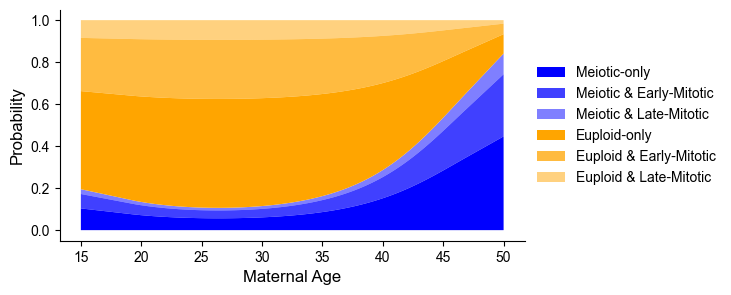

In [3]:
f_est = FecundabilityEstimator()
maternal_age = np.linspace(15, 50, 200)
# Get the relative scaling here ... 
ps = pmeiotic_age_day3(maternal_age)
# ps[ps >= 1.0] = 0.9
A = f_est.p_aneuploid()
As = [f_est.scale_meiotic_prob(A, p=a) for a in ps]
fig, ax = plt.subplots(1,1,figsize=(6,3))
prev = np.zeros(ps.size)
ax.fill_between(maternal_age, y1=prev, y2=[As[i][0,0] for i in range(ps.size)], color='blue', alpha=1.0, interpolate=True, edgecolor='none', label=r'Meiotic-only');
prev = prev + np.array([As[i][0,0] for i in range(ps.size)])
ax.fill_between(maternal_age, y1=prev, y2=prev + [As[i][1,0] for i in range(ps.size)], color='blue', alpha=0.75, interpolate=True, edgecolor='none', label=r'Meiotic & Early-Mitotic');
prev = prev + np.array([As[i][1,0] for i in range(ps.size)])
ax.fill_between(maternal_age, y1=prev, y2=prev + [As[i][2,0] for i in range(ps.size)], color='blue', alpha=0.5, interpolate=True, edgecolor='none', label=r'Meiotic & Late-Mitotic');
prev = prev + np.array([As[i][2,0] for i in range(ps.size)])
ax.fill_between(maternal_age, y1=prev, y2=prev + [As[i][0,1] for i in range(ps.size)], color='orange', alpha=1.0, interpolate=True, edgecolor='none', label=r'Euploid-only');
prev = prev + np.array([As[i][0,1] for i in range(ps.size)])
ax.fill_between(maternal_age, y1=prev, y2=prev + [As[i][1,1] for i in range(ps.size)], color='orange', alpha=0.75, interpolate=True, edgecolor='none', label=r'Euploid & Early-Mitotic');
prev = prev + np.array([As[i][1,1] for i in range(ps.size)])
ax.fill_between(maternal_age, y1=prev, y2=prev + [As[i][2,1] for i in range(ps.size)], color='orange', alpha=0.5, interpolate=True, edgecolor='none',  label=r'Euploid & Late-Mitotic');

# The probability of "least-severe categories"
# ax.plot(maternal_age, np.array([As[i][0,1] + As[i][2,1] for i in range(ps.size)]), color='black', lw=2, linestyle='--', label='Euploid-only + Euploid & Late-Mitotic')

ax.set_xlabel('Maternal Age', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
debox(ax);

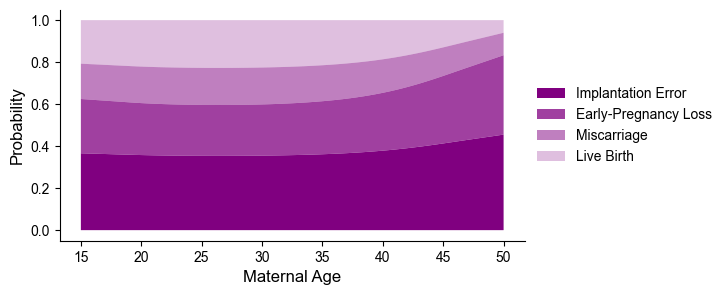

In [4]:
# Now we go through all of the potential causes for aneuploidy loss ...
outcome_probs = []
for A in As:
    p_mis, p_epl, p_implant = f_est.p_miscarriage_marginal(A = A) , f_est.p_epl_marginal(A=A), f_est.p_implant_marginal(A=A)
    outcome_probs.append([1.0 - (p_mis + p_epl + p_implant), p_mis, p_epl, p_implant])

outcome_probs = np.vstack(outcome_probs)

fig, ax = plt.subplots(1,1,figsize=(6,3))
prev = np.zeros(ps.size)
ax.fill_between(maternal_age, y1=prev, y2=outcome_probs[:,3], color='purple', alpha=1.0, interpolate=True, edgecolor='none', label=r'Implantation Error');
prev = prev + outcome_probs[:,3]
ax.fill_between(maternal_age, y1=prev, y2=prev + outcome_probs[:,2], color='purple', alpha=0.75, interpolate=True, edgecolor='none', label=r'Early-Pregnancy Loss');
prev = prev + outcome_probs[:,2]
ax.fill_between(maternal_age, y1=prev, y2=prev + outcome_probs[:,1], color='purple', alpha=0.5, interpolate=True, edgecolor='none', label=r'Miscarriage');
prev = prev + outcome_probs[:,1]
ax.fill_between(maternal_age, y1=prev, y2=prev + outcome_probs[:,0], color='purple', alpha=0.25, interpolate=True, edgecolor='none', label=r'Live Birth');

ax.set_xlabel('Maternal Age', fontsize=12)
ax.set_ylabel('Probability', fontsize=12)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
debox(ax);

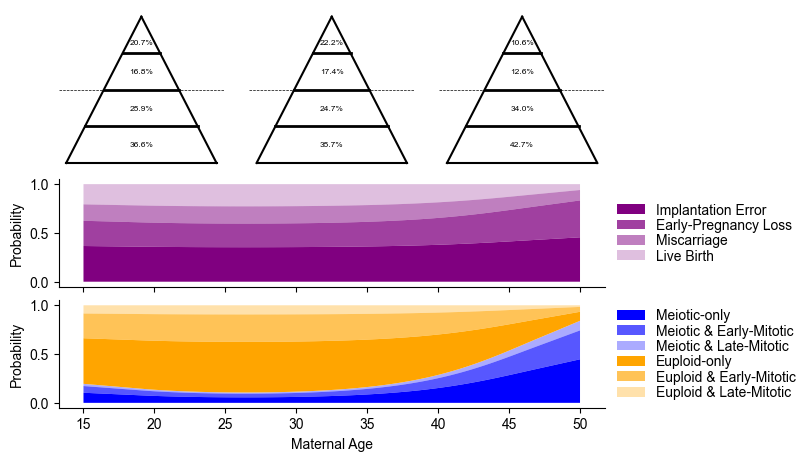

In [5]:
# Making the full composite figure ... 
from matplotlib.gridspec import GridSpec

fig = plt.figure(layout="constrained", figsize=(8,4.5))
gs = GridSpec(3, 3, figure=fig, height_ratios=[1.5,1,1])
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[0, 2])

# Plot the different macklon pyramids
FecundabilityPlotting().plot_macklon_pyramid(ax=ax1, xs=outcome_probs[0,::-1], ha='center', va='center', fontsize=6)
remove_border(ax1); remove_ticks(ax1);

FecundabilityPlotting().plot_macklon_pyramid(ax=ax2, xs=outcome_probs[100,::-1], ha='center', va='center', fontsize=6)
remove_border(ax2); remove_ticks(ax2);

FecundabilityPlotting().plot_macklon_pyramid(ax=ax3, xs=outcome_probs[180,::-1], ha='center', va='center', fontsize=6)
remove_border(ax3); remove_ticks(ax3);

ax4 = fig.add_subplot(gs[1,:])
ax5 = fig.add_subplot(gs[2, :], sharex=ax4)

# Plot the pregnancy outcomes
prev = np.zeros(ps.size)
prev = np.zeros(ps.size)
ax4.fill_between(maternal_age, y1=prev, y2=outcome_probs[:,3], color='purple', alpha=1.0, interpolate=True, edgecolor='none', label=r'Implantation Error');
prev = prev + outcome_probs[:,3]
ax4.fill_between(maternal_age, y1=prev, y2=prev + outcome_probs[:,2], color='purple', alpha=0.75, interpolate=True, edgecolor='none', label=r'Early-Pregnancy Loss');
prev = prev + outcome_probs[:,2]
ax4.fill_between(maternal_age, y1=prev, y2=prev + outcome_probs[:,1], color='purple', alpha=0.5, interpolate=True, edgecolor='none', label=r'Miscarriage');
prev = prev + outcome_probs[:,1]
ax4.fill_between(maternal_age, y1=prev, y2=prev + outcome_probs[:,0], color='purple', alpha=0.25, interpolate=True, edgecolor='none', label=r'Live Birth');

ax4.set_ylabel('Probability')
ax4.legend(loc='center left', labelspacing=.1, bbox_to_anchor=(1, 0.5), frameon=False)
debox(ax4);

# Plot the aneuploidy on the bottom axis 
prev = np.zeros(ps.size)
ax5.fill_between(maternal_age, y1=prev, y2=[As[i][0,0] for i in range(ps.size)], color='blue', alpha=1.0, interpolate=True, edgecolor='none', label=r'Meiotic-only');
prev = prev + np.array([As[i][0,0] for i in range(ps.size)])
ax5.fill_between(maternal_age, y1=prev, y2=prev + [As[i][1,0] for i in range(ps.size)], color='blue', alpha=0.66, interpolate=True, edgecolor='none', label=r'Meiotic & Early-Mitotic');
prev = prev + np.array([As[i][1,0] for i in range(ps.size)])
ax5.fill_between(maternal_age, y1=prev, y2=prev + [As[i][2,0] for i in range(ps.size)], color='blue', alpha=0.33, interpolate=True, edgecolor='none', label=r'Meiotic & Late-Mitotic');
prev = prev + np.array([As[i][2,0] for i in range(ps.size)])
ax5.fill_between(maternal_age, y1=prev, y2=prev + [As[i][0,1] for i in range(ps.size)], color='orange', alpha=1.0, interpolate=True, edgecolor='none', label=r'Euploid-only');
prev = prev + np.array([As[i][0,1] for i in range(ps.size)])
ax5.fill_between(maternal_age, y1=prev, y2=prev + [As[i][1,1] for i in range(ps.size)], color='orange', alpha=0.66, interpolate=True, edgecolor='none', label=r'Euploid & Early-Mitotic');
prev = prev + np.array([As[i][1,1] for i in range(ps.size)])
ax5.fill_between(maternal_age, y1=prev, y2=prev + [As[i][2,1] for i in range(ps.size)], color='orange', alpha=0.33, interpolate=True, edgecolor='none',  label=r'Euploid & Late-Mitotic');

# The probability of "least-severe categories" ... 
# ax5.plot(maternal_age, np.array([As[i][0,1] + As[i][2,1] for i in range(ps.size)]), color='black', lw=2, linestyle='--', label='Euploid-only + Euploid & Late-Mitotic')
plt.setp(ax4.get_xticklabels(), visible=False)

ax5.set_xlabel('Maternal Age')
ax5.set_ylabel('Probability')
ax5.legend(loc='center left', labelspacing=.1,  bbox_to_anchor=(1, 0.5), frameon=False)
debox(ax5);
plt.savefig('../doc/figures/model_figure.042024.pdf', dpi=300, bbox_inches='tight')
plt.savefig('../doc/figures/model_figure.042024.png', dpi=300, bbox_inches='tight')